In [261]:
np.dot(np.array([1,2]), np.array([[1, 2], [3, 4], [4, 5]]).T) + 1

array([ 6, 12, 15])

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions

%matplotlib widget

def linear_kernel(x1, x2):
    return x1.T @ x2

def polynomial_kernel(x1, x2, power=2):
#     print(x1.shape)
#     print(x2.shape)
    if (x1.shape[0] != x2.shape[0]):
#         print(x1.shape)
#         print(x2.shape)
#         print(x1[:, np.newaxis].shape)
        temp_result = (1 + np.dot(x1, x2.T))
        return (temp_result) ** power
    else:
        return (1 + np.dot(x1.T, x2)) ** power

class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.eps = 1e-3
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = polynomial_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
       
    def predict(self, x, return_score=False):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)
#         print('Score is ')
#         print(score)
#         print('Max score is ')
#         print(np.max(score))

        if return_score:
            return score
        else:            
            if type(score) is np.ndarray:
                score[score < 0] = -1
                score[score >= 0] = 1

                return score
            else:
                return -1 if score < 0 else 1
        
    def objective_function(self, alphas, target, kernel, x):
#         print('Shape target')
#         print(target.shape)
#         print('Shape kernel')
#         print(X_train.shape)
        return -1 * (np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(x.T, x.T) * (alphas[:, None] * alphas[None, :])))

    def smo_step(self, i1, i2):
        
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # the negative case
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
            alphas_adj = self._alphas.copy()
            alphas_adj[i2] = L
            #  Lobj = objective function at a2=L
            Lobj = self.objective_function(alphas_adj, self._targets, self._k, self._data) 
            alphas_adj[i2] = H
            # objective function at a2=H
            Hobj = self.objective_function(alphas_adj, self._targets, self._k, self._data)
            
            if Lobj < (Hobj - self.eps):
                a2 = L
            elif Lobj > (Hobj + self.eps):
                a2 = H
            else:
                a2 = alpha2
        
        if a2 < 1e-8:
            a2 = 0.0
        elif a2 > (self._c - 1e-8):
            a2 = self._c
        
        if np.abs(a2 - alpha2) < self.eps * (a2 + alpha2 + self.eps):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # Push error cache to 0 or C if very close
        for index, alph in zip([i1, i2], [a1, a2]):
            if 0.0 < alph < self._c:
                self._error_cache[index] = 0.0
        
        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Heuristic for second multiplier: get i1 with lowest absolute error |e1 - e2|
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [333]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [334]:
model = svm(c=5.0)
model.fit(samples, targets)
print(model._weights)
print(model._b)

[ 0.64361314 -0.8434502 ]
-0.17995883849775618


weights=[ 0.64361314 -0.8434502 ]
b=-0.17995883849775618


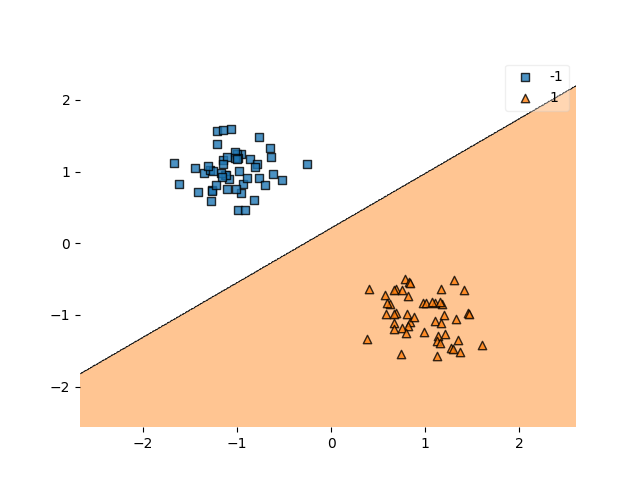

In [335]:
# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")


print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

coef_=[[ 0.67871293 -0.74096489]]
intercept=[0.0527492]


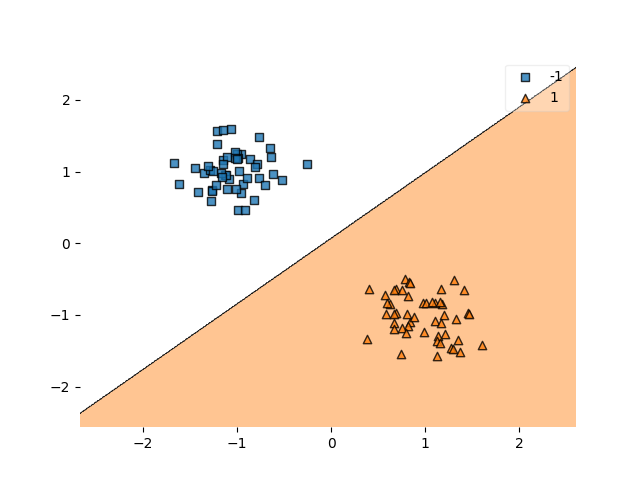

In [358]:
from sklearn.svm import LinearSVC


model = LinearSVC()
model.fit(samples, targets.astype(np.int32))

print(f"coef_={model.coef_}")
print(f"intercept={model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

[-1.64047202 -0.71101966]
-0.5139903552506
weights=[-1.64047202 -0.71101966]
b=-0.5139903552506
Accuracy: 0.3


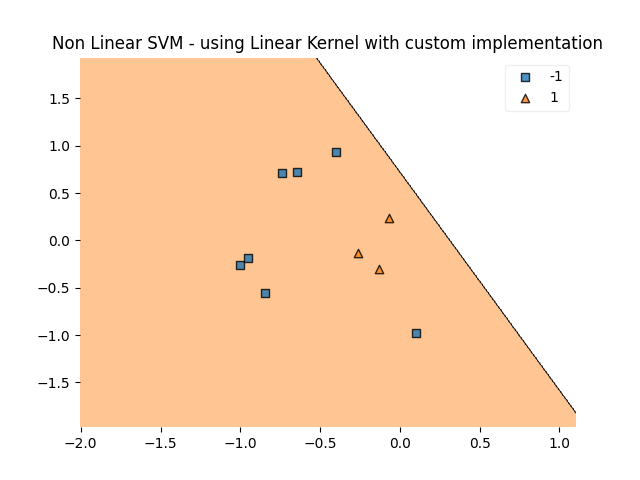

In [360]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=42)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# print(X.shape, y.shape)


model = svm(c=5.0)
model.fit(X_train, y_train)
print(model._weights)
print(model._b)


# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")


print(f"weights={model._weights}")
print(f"b={model._b}")

print('Accuracy: ' + str(accuracy_score(y_test, model.predict(X_test))))

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), model)
fig.add_subplot(ax)
plt.title("Non Linear SVM - using Linear Kernel with custom implementation")
plt.show()

coef_=[[-0.16478787  0.03502846]]
intercept=[0.05376975]
Accuracy: 0.3


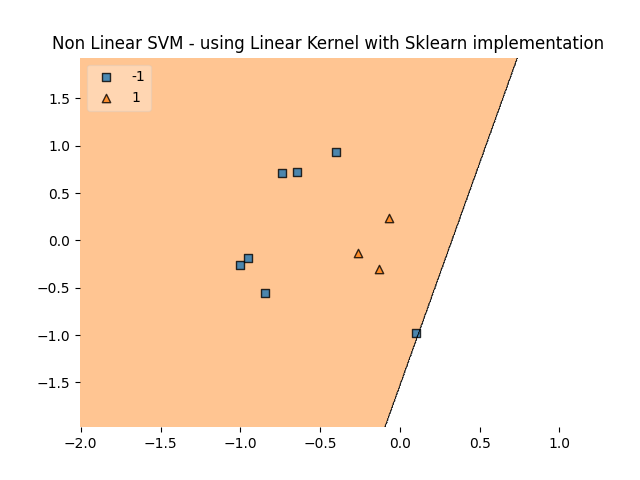

In [363]:
model = LinearSVC()
model.fit(X_train, y_train)

print(f"coef_={model.coef_}")
print(f"intercept={model.intercept_}")

print('Accuracy: ' + str(accuracy_score(y_test, model.predict(X_test))))

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test, model, legend=2)
fig.add_subplot(ax)
plt.title("Non Linear SVM - using Linear Kernel with Sklearn implementation")
plt.show()

Accuracy: 1.0


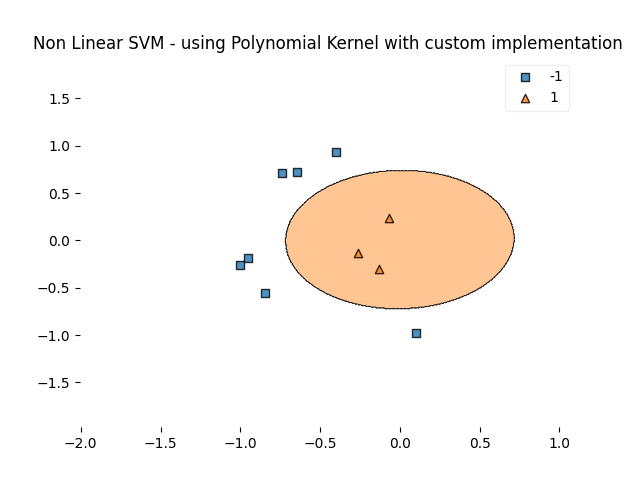

In [351]:
X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=42)
y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = svm(kernel='poly', c=1.0, maxiter=1000)
model.fit(X_train, y_train.astype(np.int32))
print('Accuracy: ' + str(accuracy_score(y_test, model.predict(X_test))))

# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), model)
fig.add_subplot(ax)
plt.title("Non Linear SVM - using Polynomial Kernel with custom implementation")
plt.show()

Accuracy: 0.3


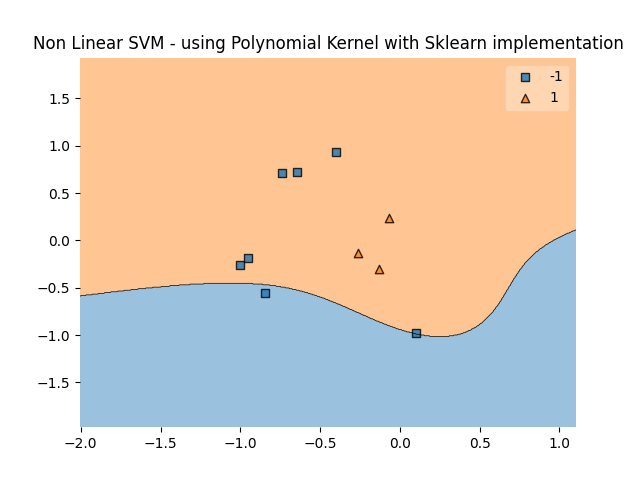

In [352]:
from sklearn.svm import SVC

model = SVC(kernel='poly')

model.fit(X_train, y_train.astype(np.int32))
print('Accuracy: ' + str(accuracy_score(y_test, model.predict(X_test))))

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), rbf_svc)
fig.add_subplot(ax)
plt.title("Non Linear SVM - using Polynomial Kernel with Sklearn implementation")
plt.show()

In [353]:
class MultiSVM:
    
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self.classifiers = None
        self.kernel = kernel
        self.c = c
        self.tol = tol
        self.maxiter = maxiter
    
    def fit(self, data, targets):
#         print(data.shape)
#         print(targets.shape)
        
        unique_targets = np.unique(targets)
        num_unique_elem = len(unique_targets)
        self.classifiers = [svm(kernel=self.kernel, c=self.c, tol=self.tol, maxiter=self.maxiter) for i in range(num_unique_elem)]
        # now we have to construct datasets based on unique target using One vs All approach
        for index, classification in enumerate(unique_targets):
#             print(data)

#             print('classification shape')
#             print(np.where(targets == classification))
            
            data0_for_current_classification = np.take(data, np.where(targets == classification), axis=0)[0]
#             print('Example')
#             print(data0_for_current_classification[0])
#             print('Targets:')
#             print(targets)
            target0_for_current_classification = targets[targets == classification]
#             print('Target0')
#             print(target0_for_current_classification)
            data1_for_current_classification = np.take(data, np.where(targets != classification), axis=0)[0]
            target1_for_current_classification = targets[targets != classification]
            
#             print('Data0 shape')
#             print(data0_for_current_classification.shape)
#             print(target0_for_current_classification.shape)
#             print(data1_for_current_classification.shape)
#             print(target1_for_current_classification.shape)
            
            # there should only be as many data points as the least number of classification examples
            # this is to ensure equality between target0 & target1 datasets when being trained
            datapoints_considered = min(len(data0_for_current_classification),
                                           len(target0_for_current_classification),
                                           len(data1_for_current_classification),
                                           len(target1_for_current_classification))
#             print('Num data points considered: ' + str(datapoints_considered))
            data0_for_current_classification = data0_for_current_classification[:datapoints_considered]
#             print('Data0 considered shape')
#             print(data0_for_current_classification.shape)
            target0_for_current_classification = target0_for_current_classification[:datapoints_considered]
            data1_for_current_classification = data1_for_current_classification[:datapoints_considered]
            target1_for_current_classification = target1_for_current_classification[:datapoints_considered]
#             print('Target1 considered shape')
#             print(target1_for_current_classification.shape)
            
            # now convert the predictions to 1s & -1s for SVM prediction
            target0_for_current_classification = np.ones_like(target0_for_current_classification)
            target1_for_current_classification = -1 * np.ones_like(target1_for_current_classification)
                                                       
            data_for_current_classification = np.concatenate((data0_for_current_classification, data1_for_current_classification), axis=0)
            target_for_current_classification = np.concatenate((target0_for_current_classification, target1_for_current_classification), axis=0)

            random_shuffling = np.random.permutation(len(data_for_current_classification))
#             print('Random shuffling')
#             print(random_shuffling)
            data_for_current_classification = data_for_current_classification[random_shuffling]
            target_for_current_classification = target_for_current_classification[random_shuffling]
                          
#             print('Test data shape')
#             print(data_for_current_classification.shape)
#             print('Test target shape')
#             print(target_for_current_classification.shape)
            
#             print('Fitting classifier: ' + str(index))
            self.classifiers[index].fit(data_for_current_classification, target_for_current_classification)
                                                       
    def predict(self, X_test):
        y_out = None
        for classifier in self.classifiers:
            if y_out is not None:
                y_out = np.column_stack((y_out, classifier.predict(X_test, return_score=True)))
            else:
                y_out = classifier.predict(X_test, return_score=True)
#             print('y_out so far')
#             print(y_out)
#             print(y_out.shape)
        # now find the max of the array of Y vectors & that will give you the indexes to find out the classification
        return y_out.argmax(axis=1)
                                                    

In [354]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

# print(iris.data)
# print(iris.target)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, random_state=42)      
multi_svm = MultiSVM()
multi_svm.fit(X_train, y_train)
y_pred = multi_svm.predict(X_test)
# print('Y_pred')
# print(y_pred)
# print('Y_test')
# print(y_test)
print('Accuracy for MultiSVM with linear kernel on Iris dataset: ' + str(accuracy_score(y_test, y_pred)))

[DEBUG] smo_step: eta = 0.0
Accuracy for MultiSVM with linear kernel on Iris dataset: 0.8666666666666667


In [355]:
## NOTE: takes too long to converge...
multi_svm = MultiSVM(kernel='poly')
multi_svm.fit(X_train, y_train)
y_pred = multi_svm.predict(X_test)
# print('Y_pred')
# print(y_pred)
# print('Y_test')
# print(y_test)
print('Accuracy for MultiSVM with Polynomial kernel on Iris dataset: ' + str(accuracy_score(y_test, y_pred)))

[DEBUG] smo_step: eta = 0.0
[DEBUG] smo_step: eta = 0.0
Accuracy for MultiSVM with Polynomial kernel on Iris dataset: 0.9333333333333333


In [356]:
model = LinearSVC()
model.fit(X_train, y_train.astype(np.int32))

print('Accuracy for Sklearn SVM with linear kernel on Iris dataset: ' + str(accuracy_score(y_test, model.predict(X_test))))


Accuracy for Sklearn SVM with linear kernel on Iris dataset: 1.0


C:\Users\pravu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [357]:
model = SVC(kernel='poly')
model.fit(X_train, y_train.astype(np.int32))
print('Accuracy for Sklearn SVM with Polynomial kernel on Iris dataset: ' + str(accuracy_score(y_test, model.predict(X_test))))


Accuracy for Sklearn SVM with Polynomial kernel on Iris dataset: 0.9333333333333333
